In [5]:
import pandas as pd
import numpy as np
import sys
import timeit
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
# change the location of the downloaded test file as necessary.
infile="data/train.csv"
#infile="kaggle/sample.csv"
outfile="data/sample_solution.csv"
intestfile="data/test.csv"

In [7]:
# Make sure you are using 64-bit python.
if sys.maxsize < 2**32:
    print ("You seem to be running on a 32-bit system ... this dataset might be too large.")
else:
    print ("Hurray! 64-bit.")

Hurray! 64-bit.


#Following steps are used to predict the average rainfall in the observation centers
#1. Two independent variables are considered Ref and Refcomposite from the train.csv set 
#2. The dependent variable is the expected rainfall
#3. A multivariate linear model is used for fitting
#4. Single variable linear regression yields a lesser score than multivariate variable
#5. Finally the expected values are derived using the Ref and Refcomposite from the test set
#6. The python script predicts the average rainfall for each ID



In [8]:
train_df = pd.read_csv(infile, usecols = ['Id','Ref','minutes_past','RefComposite','Expected'])
#print(train_df['Expected'].describe())

In [9]:
# grouping the rows based on id and get the rainfall #
train_df_grouped = train_df.groupby(['Id'])
exp_rainfall_sort = np.sort(np.array(train_df_grouped['Expected'].aggregate('mean')))

/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


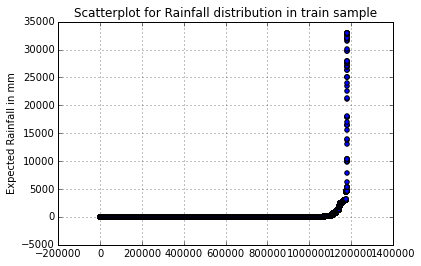

In [10]:
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(exp_rainfall_sort.shape[0]), exp_rainfall_sort)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Expected Rainfall in mm")
plt.savefig("ExpectedRainfall1.png")
plt.grid(True)
plt.show()


In [11]:
exp_rainfall = train_df_grouped['Expected'].aggregate('mean')

In [12]:
train_df_copy = train_df

In [13]:
def marshall_palmer(ref,minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    
    minutes_past = minutes_past.sort_values(ascending=True)
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in range(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0.0
    for dbz, hours in zip(ref, valid_time):
        # See: https://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    mean_val_ref = sum/float(len(ref))
    
    return (mean_val_ref)  
 
# each unique Id is an hour of data at some gauge
def myfunc(train_df):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    #train_df = train_df.sort('minutes_past', ascending=True)
    est = marshall_palmer(train_df['Ref'],train_df['minutes_past'])
    return est

# this writes out the file, but there is a bug in dask
# where the column name is '0': https://github.com/blaze/dask/pull/621
ref_g = train_df_grouped.apply(myfunc)

In [14]:
ref_g_safe = ref_g

In [15]:
def marshall_palmer(refcom, minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    minutes_past = minutes_past.sort_values(ascending=True)
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in range(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0
    for dbz, hours in zip(refcom, valid_time):
        # See: https://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    mean_val = sum/float(len(refcom))
    return mean_val


# each unique Id is an hour of data at some gauge
def myfunc(train_df):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    est = marshall_palmer(train_df['RefComposite'], train_df['minutes_past'])
    return est

# this writes out the file, but there is a bug in dask
# where the column name is '0': https://github.com/blaze/dask/pull/621
refcom_m = train_df_grouped.apply(myfunc)

In [16]:
refcom_safe = refcom_m

In [17]:
len(ref_g),len(refcom_m),len(exp_rainfall)

(1180945, 1180945, 1180945)

/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


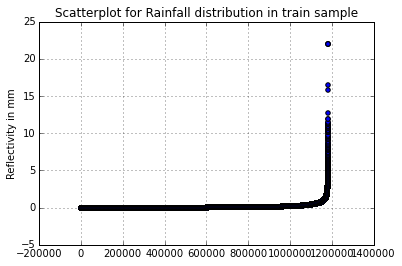

In [18]:

ref_g_sort = np.sort(np.array(ref_g))
plt.figure()
plt.scatter(np.arange(ref_g_sort.shape[0]), ref_g_sort)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Reflectivity in mm")
plt.savefig("Reflectivity1.png")
plt.grid(True)
plt.show()




/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


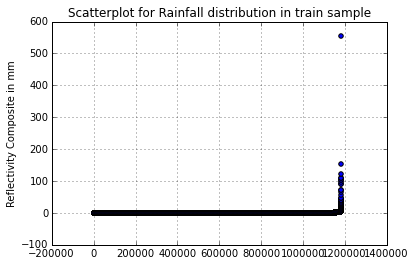

In [19]:
refcom_sort = np.sort(np.array(refcom_m))
plt.figure()
plt.scatter(np.arange(refcom_sort.shape[0]), refcom_sort)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Reflectivity Composite in mm")
plt.savefig("ReflectivityComposite1.png")
plt.grid(True)
plt.show()


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


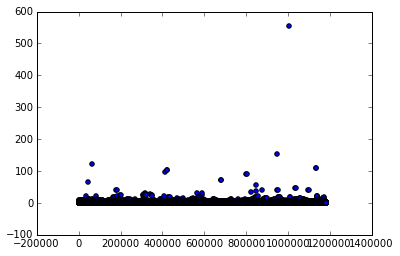

In [20]:
plt.scatter(np.arange(refcom_m.shape[0]),refcom_m)

Threshold Value : 0.25400013


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


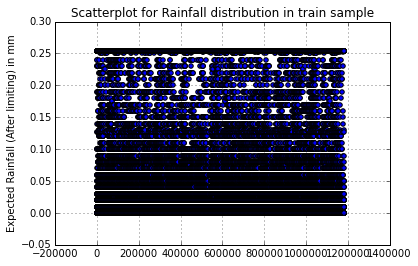

In [21]:
exp_thr = max(exp_rainfall_sort[0:100000])
print ("Threshold Value :",exp_thr)
exp_rainfall[ exp_rainfall > exp_thr ] = 0.0 # Set the large values to 0
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(exp_rainfall.shape[0]), exp_rainfall)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Expected Rainfall (After limiting) in mm")
plt.savefig("ExpectedRainfall2.png")
plt.grid(True)
plt.show()


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


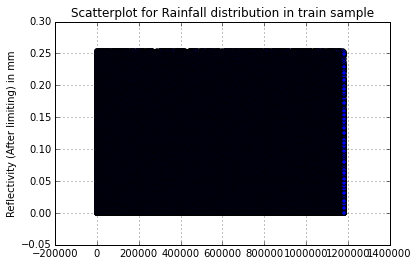

In [22]:
ref_g[ ref_g > exp_thr ] = 0.0 # Set the large values to 0
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(ref_g.shape[0]), ref_g)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Reflectivity (After limiting) in mm")
plt.savefig("ReflectivityRainfall2.png")
plt.grid(True)
plt.show()


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


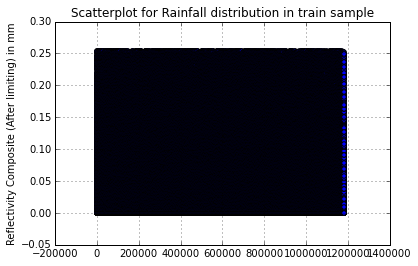

In [23]:
refcom_m[ refcom_m > exp_thr ] = 0.0 # Set the large values to 0
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(refcom_m.shape[0]), refcom_m)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Reflectivity Composite (After limiting) in mm")
plt.savefig("ReflectivityCompositeRainfall2.png")
plt.grid(True)
plt.show()


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


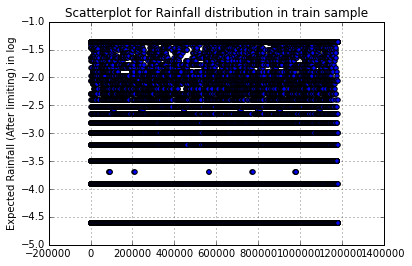

In [24]:
exp_log = np.log(exp_rainfall)
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(exp_log.shape[0]), exp_log)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Expected Rainfall (After limiting) in log")
plt.savefig("ExpectedRainfalllog3.png")
plt.grid(True)
plt.show()


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


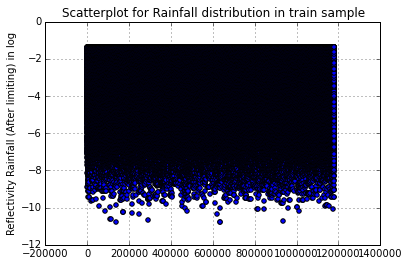

In [25]:
ref_g_log = np.log(ref_g)
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(ref_g_log.shape[0]), ref_g_log)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Reflectivity Rainfall (After limiting) in log")
plt.savefig("ReflectivityRainfalllog4.png")
plt.grid(True)
plt.show()


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


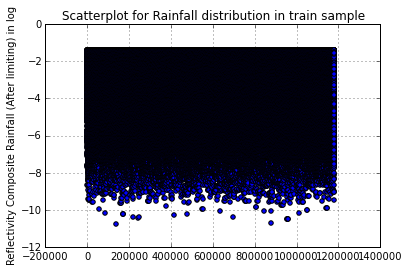

In [26]:

refcom_m_log = np.log(refcom_m)
# plotting a scatter plot #
plt.figure()
plt.scatter(np.arange(refcom_m_log.shape[0]), refcom_m_log)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Reflectivity Composite Rainfall (After limiting) in log")
plt.savefig("ReflectivityCompositeRainfalllog5.png")
plt.grid(True)
plt.show()



In [27]:

ref_g_log[~np.isfinite(ref_g_log)] = 0.0

refcom_m_log[~np.isfinite(refcom_m_log)] = 0.0

exp_log[~np.isfinite(exp_log)] = 0.0

ref_g_log.shape,refcom_m_log.shape,exp_log.shape


((1180945,), (1180945,), (1180945,))

In [52]:
from sklearn.metrics import r2_score
#Do multivariate linear fit between Ref,RefComposite Vs Expected 
from scipy.optimize import curve_fit
import scipy
def fn(x, a, b, c):
    return a + b*x[0] + c*x[1]


x_com = scipy.array([ref_g_log,refcom_m_log])

popt, pcov = curve_fit(fn, x_com, exp_log)
perr = np.sqrt(np.diag(pcov))
print (popt[0],popt[1],popt[2])
print (pcov)
print (perr)
exp_hat_log = popt[0] + ref_g_log*popt[1] + refcom_m_log*popt[2]

print("Score",r2_score(exp_log,exp_hat_log))


-0.455921053384 -0.00725588063721 0.036519480757
[[  1.21400314e-06   3.12568096e-07  -1.65419477e-08]
 [  3.12568096e-07   1.41291929e-06  -1.35875202e-06]
 [ -1.65419477e-08  -1.35875202e-06   1.48765733e-06]]
[ 0.00110182  0.00118866  0.0012197 ]
Score 0.00409765657753


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


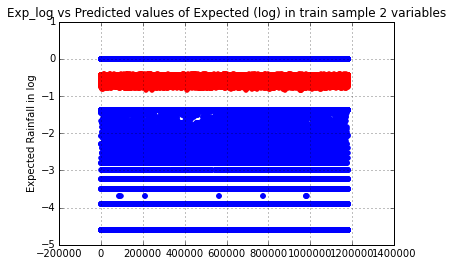

In [29]:
plt.figure()
plt.scatter(np.arange(exp_log.shape[0]), exp_log,color='blue')
plt.scatter(np.arange(exp_hat_log.shape[0]), exp_hat_log,color='red')
plt.grid(True)
plt.title("Exp_log vs Predicted values of Expected (log) in train sample 2 variables")
plt.ylabel("Expected Rainfall in log")
plt.savefig("ExplogvsExplogPredicted2variableslog6.png")
plt.grid(True)
plt.show()

In [47]:
from sklearn.metrics import r2_score
#Do multivariate linear fit between Ref,RefComposite Vs Expected 
from scipy.optimize import curve_fit
import scipy
def fn(x, a, b):
    return a + b*x[0]


x_com = scipy.array([ref_g_log])

popt1, pcov1 = curve_fit(fn, x_com, exp_log)
perr1 = np.sqrt(np.diag(pcov))
print (popt1[0],popt1[1])
print (pcov1)
print (perr1)
exp_hat_log = popt1[0] + ref_g_log*popt1[1]

print("Single independent Variable Score",r2_score(exp_log,exp_hat_log))


-0.455514976642 0.0260991916925
[[  1.21473964e-06   2.97685066e-07]
 [  2.97685066e-07   1.72033310e-07]]
[ 0.00110215  0.00041477]
Single independent Variable Score 0.00334163451724


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


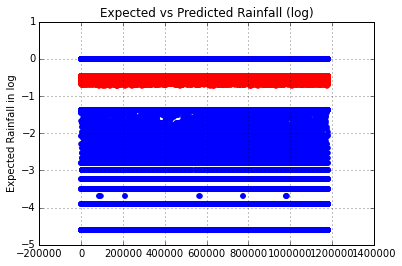

In [48]:
plt.figure()
plt.scatter(np.arange(exp_log.shape[0]), exp_log,color='blue')
plt.scatter(np.arange(exp_hat_log.shape[0]), exp_hat_log,color='red')
plt.grid(True)
plt.title("Expected vs Predicted Rainfall (log) ")
plt.ylabel("Expected Rainfall in log")
plt.savefig("ExplogvsExplogPredicted1variableslog6.png")
plt.grid(True)
plt.show()

(0, 1180945)

/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


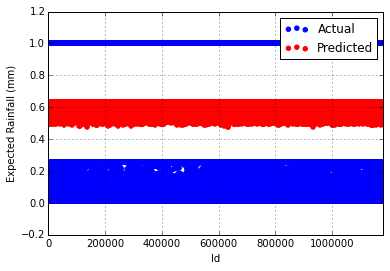

In [32]:
exp_nat = np.exp(exp_log)
exp_nat_hat = np.exp(exp_hat_log)
plt.figure()
plt.scatter(np.arange(exp_nat.shape[0]), exp_nat,color='blue',label = 'Actual')
plt.scatter(np.arange(exp_nat_hat.shape[0]), exp_nat_hat,color='red',label = 'Predicted')
plt.ylabel("Expected Rainfall (mm)")
plt.legend( loc='upper left', numpoints = 1 )
plt.xlabel("Id")
plt.legend()
plt.grid(True)
plt.xlim(0,len(exp_nat))


#Following section of the code will do the actual prediction on the test data
#Since 2 independent variable predict better than single variable it is useful 
#to find the relationship between Ref and Refcomposite in train data.
#Apply the coefficients to find the Refcom on test set.
#Eventually predict the Expected values in test.csv

In [43]:
test_df = pd.read_csv(intestfile,usecols = ['Id','Ref','minutes_past','RefComposite'])

In [44]:
# grouping the rows based on id and get the rainfall #
test_df_grouped = test_df.groupby(['Id'])

In [45]:
def marshall_palmer(ref,minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    
    minutes_past = minutes_past.sort_values(ascending=True)
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in range(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0.0
    for dbz, hours in zip(ref, valid_time):
        # See: https://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    mean_val_ref = sum/float(len(ref))
    
    return (mean_val_ref)  
 
# each unique Id is an hour of data at some gauge
def myfunc(test_df):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    #train_df = train_df.sort('minutes_past', ascending=True)
    est = marshall_palmer(test_df['Ref'],test_df['minutes_past'])
    return est

# this writes out the file, but there is a bug in dask
# where the column name is '0': https://github.com/blaze/dask/pull/621
ref_g_test = test_df_grouped.apply(myfunc)
ref_g_test_safe = ref_g_test

In [46]:
def marshall_palmer(refcom,minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    
    minutes_past = minutes_past.sort_values(ascending=True)
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in range(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0.0
    for dbz, hours in zip(refcom, valid_time):
        # See: https://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    mean_val_ref = sum/float(len(refcom))
    
    return (mean_val_ref)  
 
# each unique Id is an hour of data at some gauge
def myfunc(test_df):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    #train_df = train_df.sort('minutes_past', ascending=True)
    est = marshall_palmer(test_df['RefComposite'],test_df['minutes_past'])
    return est

# this writes out the file, but there is a bug in dask
# where the column name is '0': https://github.com/blaze/dask/pull/621
refcom_g_test = test_df_grouped.apply(myfunc)
refcom_g_test_safe = refcom_g_test

In [55]:

print(ref_g_test.shape,refcom_g_test.shape)
exp_test_hat_log = popt[0] + ref_g_test*popt[1] + refcom_g_test*popt[2]
exp_test_hat = np.exp(exp_test_hat_log)

(717625,) (717625,)


/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


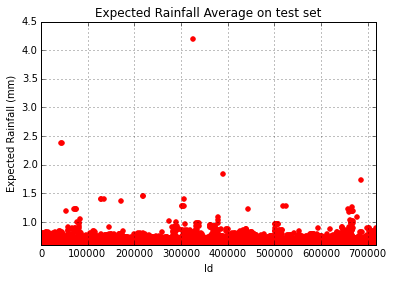

In [56]:
plt.figure()
plt.scatter(np.arange(exp_test_hat.shape[0]), exp_test_hat,color='red')
plt.grid(True)
plt.title("Expected Rainfall Average on test set")
plt.ylabel("Expected Rainfall (mm) ")
plt.xlabel("Id")
plt.savefig("ExpectedRainfalltest7.png")
plt.grid(True)
plt.xlim(0,len(exp_test_hat))
plt.ylim(0.6,4.5)
plt.show()

In [58]:
exp_test_hat.describe()

count    717625.000000
mean          0.657164
std          17.350622
min           0.633864
25%           0.633864
50%           0.634072
75%           0.635991
max       14698.823027
dtype: float64

In [59]:
Ref_test_len = test_df_grouped.Ref.size()

/Users/venkateshviswanathan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


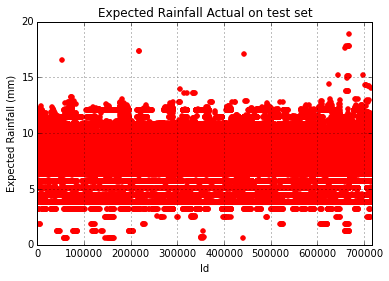

In [60]:
actualrainfall = exp_test_hat*Ref_test_len
plt.figure()
plt.scatter(np.arange(actualrainfall.shape[0]), actualrainfall,color='red')
plt.grid(True)
plt.title("Expected Rainfall Actual on test set")
plt.ylabel("Expected Rainfall (mm) ")
plt.xlabel("Id")
plt.savefig("ExpectedRainfallactualtest8.png")
plt.grid(True)
plt.xlim(0,len(actualrainfall))
plt.ylim(0,20)
plt.show()